# 1. Setup

In [2]:
import plotly.express as px
from pyarrow.parquet import read_metadata
import yaml

from utils import *

# 2. Prepare data


## 2.1. Download with OSRM
With Open Source Routing Machine (OSRM) backend server ([OSRM-backend](https://github.com/Project-OSRM/osrm-backend)), a local server was set up in `osrm.sh` and `osrm.py` was used to process the origin-destination (OD) distance/travel time data.

## 2.2. Check data completeness

In [3]:
def check_quality(level, year=2020):
    ideal = (pd.read_parquet(f'../data/zones/export/{level}_{year}.parquet')
             .rename(columns={level: 'region'})
             .astype(D(scale=str, region=str))
             .groupby(['region', 'scale']).size()
             .apply(lambda x: x ** 2 - x).rename('ideal').reset_index())
    actual = Pdf([D(region=f.split('/')[-2],
                    scale=f.split('/')[-1].split('_')[0],
                    mode=f.split('/')[-1].split('_')[1],
                    actual=read_metadata(f).num_rows)
                  for f in glob(f'../data/osrm/{level}/*/*_{year}.parquet')])
    actual = actual.pivot_table('actual', ['region', 'scale'], 'mode')
    modes = ['bike', 'drive', 'walk']
    df = (ideal.merge(actual, 'left', on=('region', 'scale'))
           .fillna(0).astype({x: int for x in modes}))
    for mode in modes:
        df[f'pct_{mode}'] = df[mode] / df['ideal'] * 100
    return df

### 2.2.1. State-level

In [4]:
# comp_state = check_quality('state').disp()

In [5]:
# comp_state.query('ideal!=bike | bike!=drive | drive!=walk | walk!=bike')

### 2.2.2. MSA-level

In [6]:
comp_msa = check_quality('msa').disp()

150 rows x 9 cols; Memory: 0.0 MiB


,region,scale,ideal,bike,drive,walk,pct_bike,pct_drive,pct_walk
,<object>,<object>,<int64>,<int64>,<int64>,<int64>,<float64>,<float64>,<float64>
0,atlanta,bg,15598550,1800026,14014871,207976,11.539701,89.847268,1.333303


In [7]:
# comp_msa.query('ideal!=bike | bike!=drive | drive!=walk | walk!=bike')

# 3. Analyze

## 3.1. OSRM vs GDM

In [8]:
def get_osrm_vs_gdm():
    gdm = (pd.read_parquet('../data/gdm/odp_in_2010.parquet')
           .query('scale != "county" & mode != "transit" & day_type == "weekday"')
           .drop(columns=['day_type', 'speed'])
           .rename(columns=D(dist='distance', time='duration')))
    osrm = pd.concat([
        pd.read_parquet(f, filters=[('duration', '<=', 90 * 60)])
        .assign(**D(zip(['scale', 'mode'], Path(f).stem.split('_')[:2])))
        for f in glob('../data/osrm/indiana/*_2010.parquet')])
    od = gdm.merge(osrm, on=['src_geoid', 'trg_geoid', 'scale', 'mode'],
                   suffixes=['_gdm', '_osrm'])
    od = pd.concat([od[['scale', 'mode', f'distance_{src}', f'duration_{src}']]
                    .rename(columns=lambda x: x.replace(f'_{src}', ''))
                    .assign(source=src) for src in ['gdm', 'osrm']])
    od = od.reset_index(drop=1).astype(D(source=CAT, scale=CAT, mode=CAT))
    od['speed'] = od['distance'] / (od['duration'] + 1e-6)
    # convert from SI units to readable units (mi, min, mi/h)
    od.distance /= MI2M; od.duration /= 60; od.speed *= MPS2MPH
    od = od.astype({x: np.float32 for x in ['distance', 'duration', 'speed']})
    return od

odIN10 = get_osrm_vs_gdm().disp() # t=0:16

11,477,978 rows x 6 cols; Memory: 164.2 MiB


,scale,mode,distance,duration,source,speed
,<category>,<category>,<float32>,<float32>,<category>,<float32>
0,bg,bike,1.047013,6.066667,gdm,10.355048


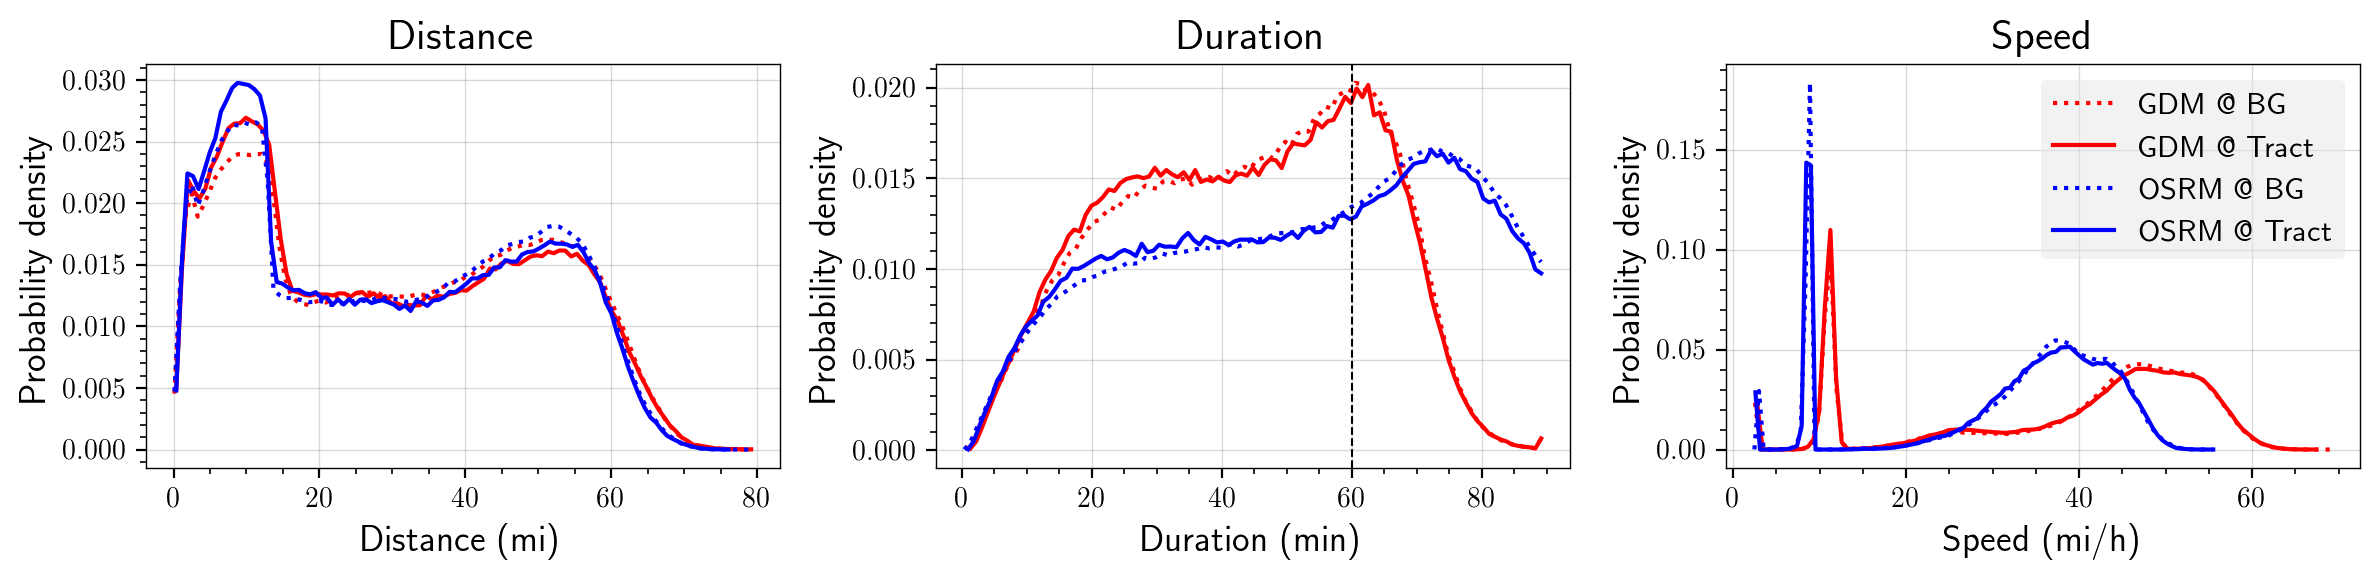

In [9]:
# t=0:06
_, axes = plt.subplots(1, 3, figsize=(12, 3), dpi=200)
for i, (var, unit, vmax) in enumerate([
        ('distance', 'mi', 80), ('duration', 'min', 90), ('speed', 'mi/h', 70)]):
    ax = pplot(axes[i], title=var.title(), xlab=f'{var.title()} ({unit})',
               ylab='Probability density')
    for source, color in [('gdm', 'r'), ('osrm', 'b')]:
        for scale, ls in [('BG', ':'), ('Tract', '-')]:
            val = odIN10.query(f'source=="{source}" & scale=="{scale.lower()}"')[var]
            y, x = np.histogram(val.clip(0, vmax), bins=100, density=True)
            ax.plot(x[:-1], y, color=color, ls=ls, label=f'{source.upper()} @ {scale}')
    if i == 1: ax.axvline(60, lw=0.75, ls='--', color='k')
    if i == 2: ax.legend()
plt.tight_layout()

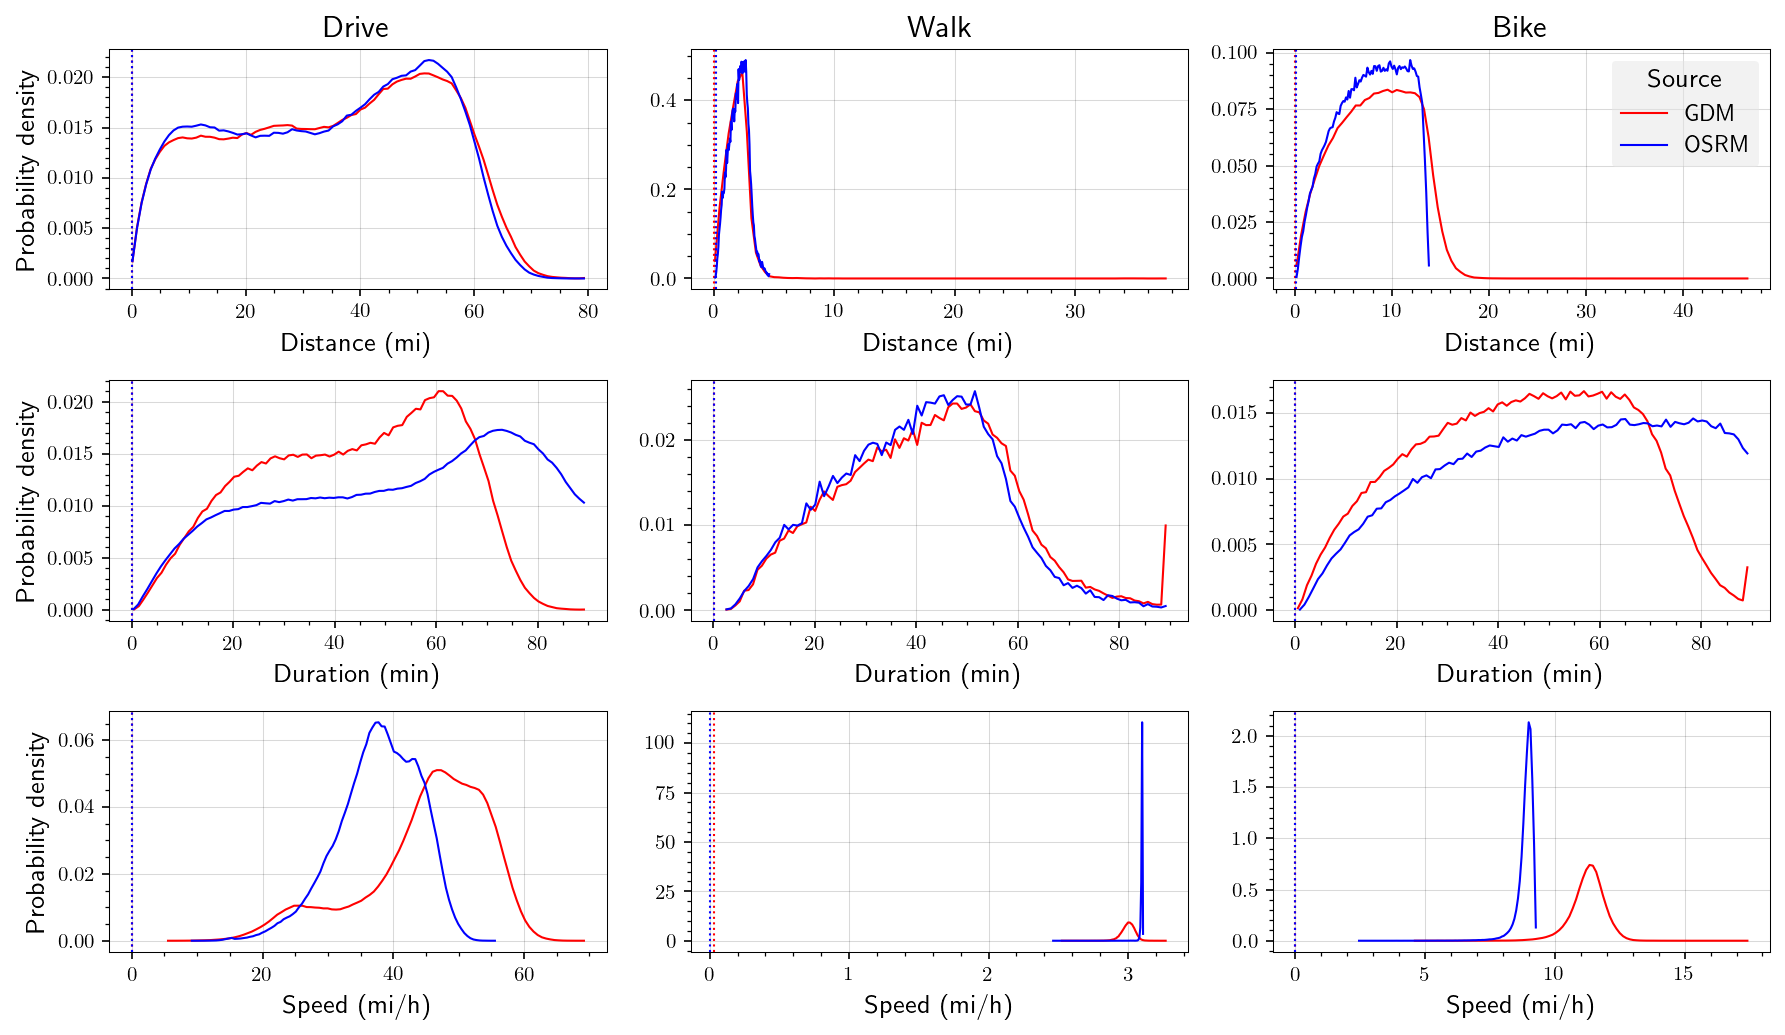

In [10]:
# t=0:11
_, axes = plt.subplots(3, 3, figsize=(12, 7), dpi=150)
for i, (var, unit, vmax) in enumerate([
        ('distance', 'mi', 80), ('duration', 'min', 90), ('speed', 'mi/h', 70)]):
    for j, mode in enumerate(['drive', 'walk', 'bike']):
        ax = pplot(axes[i, j], title=mode.title() if i == 0 else '',
                    xlab=f'{var.title()} ({unit})')
        for source, color in [('gdm', 'r'), ('osrm', 'b')]:
            df = odIN10.query(f'source=="{source}" & scale=="bg" & mode=="{mode}"')
            y = df[var].clip(0, vmax)
            y, x = np.histogram(y, bins=100, density=True)
            ax.plot(x[:-1], y, color=color, lw=1, label=source.upper())
            ax.axvline(np.median(y), color=color, lw=1, ls=':')
    axes[i, 0].set_ylabel('Probability density')
axes[0, 2].legend(title='Source', loc='upper right')
plt.tight_layout()

## 3.2. OSRM times for MSAs

### 3.2.1. Overall distributions

In [11]:
def get_distr(level, bins=100, max_vals=D(distance=90, duration=90, speed=60)):
    res = []
    for f in tqdm(glob(f'../data/osrm/{level}/*/bg_*_2020.parquet')):
        rgn = f.split('/')[-2]
        scale, mode = f.split('/')[-1].split('_')[:2]
        df = pd.read_parquet(f, columns=['distance', 'duration'])
        df = df[df.duration > 0]
        if len(df) == 0: continue
        df['distance'] /= MI2M; df['duration'] /= 60
        df['speed'] = (df['distance'] / (df['duration'] / 60)).astype(np.float32)
        for col, vmax in max_vals.items():
            vals = df[col].clip(0, vmax)
            y, x = np.histogram(vals, bins=np.linspace(0, vmax, bins + 1))
            res.append(Pdf(D(x=x[1:], y=y, ynorm=y / y.sum())).assign(
                region=rgn, scale=scale, mode=mode, measure=col))
    res = pd.concat(res)
    return res

# t=4:13
# dstr = (pd.concat([get_distr(level).assign(level=level) for level in 
#                   ['msa', 'state']]).reset_index(drop=1)
#         .astype(D(level=CAT, region=CAT, scale=CAT, mode=CAT, measure=CAT))).disp()
# dstr.to_parquet('../data/osrm/distributions.parquet')
dstr = pd.read_parquet('../data/osrm/distributions.parquet').disp()

59,700 rows x 8 cols; Memory: 1.7 MiB


,x,y,ynorm,region,scale,mode,measure,level
,<float64>,<int64>,<float64>,<category>,<category>,<category>,<category>,<category>
0,0.9,3178,0.001769,atlanta,bg,bike,distance,msa


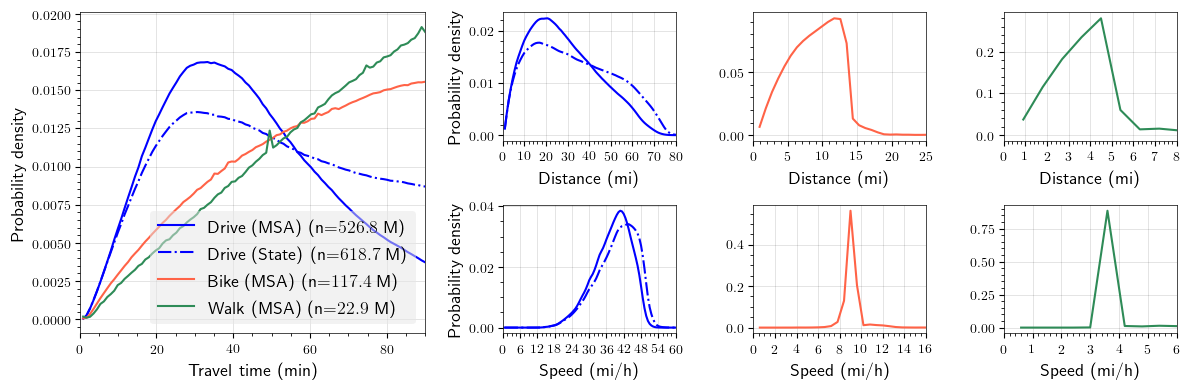

In [12]:
def plot_od_distr(distr, dpi=100):
    fig = plt.figure(figsize=(12, 4), dpi=dpi)
    gs = mpl.gridspec.GridSpec(2, 4, width_ratios=[2, 1, 1, 1])
    ylab = 'Probability density'
    mode_colors = D(drive='b', bike='tomato', walk='seagreen')
    ax1 = pplot(fig.add_subplot(gs[:, 0]), xlim=(0, 90), xlab='Travel time (min)', ylab=ylab)
    for i, var, unit in [(0, 'distance', 'mi'), (1, 'speed', 'mi/h'), (2, 'duration', 'min')]:
        for j, (mode, color) in enumerate(mode_colors.items()):
            if var == 'duration': ax = ax1
            else: ax = pplot(fig.add_subplot(gs[i, j + 1]), xlab=f'{var.title()} ({unit})', 
                             ylab=ylab if j == 0 else '')
            for level, lab, ls in [('msa', 'MSA', '-'), ('state', 'State', '-.')]:
                df = distr.query(f'measure=="{var}" & mode=="{mode}" & level=="{level}"')
                y = df.groupby('x')['y'].sum()
                n = mpl.ticker.EngFormatter(places=1)(y.sum())
                label = f'{mode.title()} ({lab}) (n={n})' if y.sum() > 0 else None
                ax.plot(y / y.sum(), color=color, ls=ls, label=label)
            if var == 'duration': continue
            xmax, gap = D(distance=D(drive=(80, 10), bike=(25, 5), walk=(8, 1)),
                          speed=D(drive=(60, 6), bike=(16, 2), walk=(6, 1)))[var][mode]
            ax.set_xticks(np.arange(0, xmax + 1, gap))
            ax.set_xlim(0, xmax)
    ax1.legend(fontsize=13)
    plt.tight_layout()
    
plot_od_distr(dstr, dpi=100)

### 3.2.2. Distribution by city

In [14]:
def plot_distr_by_msa(mode, measure='duration', data=dstr,
                      exclude_rgns=['louisville']):
    df = data.query(f'mode=="{mode}" & measure=="{measure}"')
    df = df[~df['region'].isin(exclude_rgns)]
    df = df.sort_values(['region', 'x'])
    df.region = df.region.apply(lambda x: ' '.join(
        [x.title() for x in x.split('-')]))
    unit = D(duration='min', distance='mi', speed='mi/h')[measure]
    labels = D(region='MSA', x=f'{measure.title()} ({unit})',
               ynorm='Probability density')
    fig = px.line(df, x='x', y='ynorm', color='region', width=1000, height=500,
                  title=f'{measure.title()} b/w tracts by {mode}', labels=labels)
    return fig.update_layout(font=D(family='Arial', size=18))

# plot_distr_by_msa('drive')

In [ ]:
plot_distr_by_msa('drive', 'distance')

In [ ]:
plot_distr_by_msa('walk')

In [ ]:
plot_distr_by_msa('bike')